In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.special import softmax as sft

path = "/content/drive/MyDrive/SEMESTER_5_DATA/Machine Learning/ML_Assignment_3/"

(trainX, trainy), (testX, testy) = mnist.load_data()
trainX = trainX.reshape((trainX.shape[0], 784))
testX = testX.reshape((testX.shape[0], 784))

In [2]:
class MyNeuralNetwork():

    acti_fns = ['relu', 'sigmoid', 'linear', 'tanh', 'softmax']
    weight_inits = ['zero', 'random', 'normal']
    weights = {}
    n_layers, layer_sizes, activation, learning_rate, batch_size, num_epochs, weight_init = 0,0,0,0,0,0,0
    bias = {}
    loss_train = []
    loss_test = []

    def __init__(self, n_layers, layer_sizes, activation, learning_rate, weight_init, batch_size, num_epochs):
        self.n_layers, self.layer_sizes, self.activation, self.learning_rate, self.batch_size, self.num_epochs, self.weight_init = n_layers, layer_sizes, activation, learning_rate, batch_size, num_epochs, weight_init
        self.weights = {}
        self.bias = {}
        self.loss_train = []
        self.loss_test = []
        if activation not in self.acti_fns:
            raise Exception('Incorrect Activation Function')
        if len(layer_sizes) != n_layers:
            raise Exception('Incorrect Layer Size')    
        if weight_init not in self.weight_inits:
            raise Exception('Incorrect Weight Initialization Function')
        pass

    def relu(self, X):   
        X = np.clip(X,0,10**10) # Changes the value<0 = 0 and value>10**10 = 10**10
        return X

    def relu_grad(self, X):
        X = np.clip(X,0,1)   # Changes the value<0 = 0 and value>1 = 1
        X[X>0] = 1           # Changes the 0 < value < 1 = 1
        return X             # Gradient of relu activation function 

    def sigmoid(self, X):
        X = np.clip(X,-100,100)        # Changes the value < -100 = 0 and value > 100 = 1
        z = np.exp(-X)                 # Changes the value of each element in the array to e^(-x)
        return 1/(1+z)                 # Return the sigmoid value of each element in the array

    def sigmoid_grad(self, X):
        return self.sigmoid(X)*(1-self.sigmoid(X))        #Gradient of sigmoid activation function

    def linear(self, X):
        X = np.clip(X,(-1)*10**(10),10**10)        #Pervent underflow and overflow
        return X           # Return X after linear activations

    def linear_grad(self, X):
        return np.ones(X.shape)        #Gradient of linear activation function

    def tanh(self, X):
        return np.tanh(X)       # Return X after tanh activations

    def tanh_grad(self, X):
        return 1-self.tanh(X)**2           #Gradient of linear activation function

    def softmax(self, X):
        if( self.activation == 'sigmoid' ):
            return self.softmax_con(X)
        X = np.clip(X,-100,100)                      # Changes the value < -100 = 0 and value > 100 = 1
        expo = np.exp(X)                             # Changes the value of each element in the array to e^(x)
        expo_sum = np.sum(expo, axis=0)              # Calculate the sum of    
        return expo/expo_sum[None,:]
    
    def softmax_con(self,X):
        X = X - np.max(X, axis=0, keepdims=True)   #Subtract the maximum amount from each column
        X = np.clip(X,-100,500)                    #Pervent underflow and overflow
        expo = np.exp(X)                           #Calculate softmax
        expo_sum = np.sum(expo, axis=0)
        return expo/expo_sum[None,:]

    def softmax_grad(self, X):
        return self.softmax(X)*(1-self.softmax(X))     #Gradient of softmax activation function

    def zero_init(self, shape):
        return np.zeros(shape)        #Return 2d zero array of given shape
    
    def random_init(self, shape):
        np.random.seed(20)
        return np.random.rand(shape[0],shape[1]) * 0.01               #Return 2d random array of given shape with scaling of 0.01

    def normal_init(self, shape):
        np.random.seed(20)
        return np.random.normal(scale=1, size = (shape[0],shape[1])) * 0.01       #Return 2d normal array of given shape with scaling of 0.01

    def activation_convertor(self,X):
        #Function to select the activation function selected by the user
        if( self.activation == 'relu'):
            return self.relu(X)
        elif( self.activation == 'sigmoid'):
            return self.sigmoid(X)
        elif( self.activation == 'linear'):
            return self.linear(X)
        elif( self.activation == 'tanh'):
            return self.tanh(X)
        elif( self.activation == 'softmax'):
            return self.softmax(X)

    def activation_grad_convertor(self,X):
        #Function to select the activation function selected by the user
        if( self.activation == 'relu'):
            return self.relu_grad(X)
        elif( self.activation == 'sigmoid'):
            return self.sigmoid_grad(X)
        elif( self.activation == 'linear'):
            return self.linear_grad(X)
        elif( self.activation == 'tanh'):
            return self.tanh_grad(X)
        elif( self.activation == 'softmax'):
            return self.softmax_grad(X)
    
    def new_loss(self, X,y):
        eps = np.finfo(float).eps                           # Margin to avoid log(0) 
        z, a = self.for_2(X)                                # Get the activations of the layers using forward propagation
        sample_error = np.sum(np.multiply(np.log(a[-1]+eps), y) + np.multiply((1 - y), np.log(1 - a[-1]+eps)) , axis=0)  #Calculate the cross entropy loss for each sample
        cost = -np.sum(sample_error) / y.shape[1]           #Calculate the average cross entropy loss of the total batch /input
        return cost
    
    def y_convertor(self,y):
        b = np.zeros((y.size, y.max()+1))               #Create a number zero array if the (nsamples, y.max()+1 - 0)
        b[np.arange(y.size),y] = 1                      #Sets element = 1 if the value of y equals the coloumn index
        return b.T
    
    def weight_generate(self):
        '''
        Function initializes the weights according to the weight_init
        parameter given by the user. Also initializes the bias as 0.
        '''
        for i in range(1, self.n_layers):
            if self.weight_init == 'zero':
                self.weights[i] = self.zero_init( (self.layer_sizes[i],self.layer_sizes[i-1]) )        #Set the ith weights set to be zero
            elif self.weight_init == 'random':
                self.weights[i] = self.random_init( (self.layer_sizes[i],self.layer_sizes[i-1]) )      #Set the ith weights set to be random distribution with scaling of 0.01
            else:
                self.weights[i] = self.normal_init( (self.layer_sizes[i],self.layer_sizes[i-1]) )      #Set the ith weights set to be normal distribution (mean = 0 and variance = 1) with scaling of 0.01
            self.bias[i] = np.zeros(shape=(self.layer_sizes[i], 1))                                    #Set the ith layer neuron bias to 0 
    
    def for_2(self,X):
        '''
        Function used for forward propagation.
        Takes trainX as input in the form (nfeatures, nsampples).
        '''
        z = [X]    
        a = [X]
        for i in range(1,self.n_layers):
            Z1 = np.dot(self.weights[i],X) + self.bias[i]   # Weighted sum of activations from previous layer + bias
            z.append(Z1)   #Append in z
            if(i == self.n_layers-1):                       # To check if this is the final layer
                A1 = self.softmax(Z1)                       # If final layer then add softmax function as activation function
            else:
                A1 = self.activation_convertor(Z1)          # Use the activation function initialized by user
            a.append(A1)                                    # Add activations of the layer
            X = A1                                          # Change the X to activation of the layer
        return z, a  

    def fitter(self,X,y):
        '''
        Input :
        X - 2d array of the form ( nfeatures , nsamples) Training data
        y - 2d array of the form (1, nsamples)   Class labels 
        Usage - 
        Helper function for fit to perform batch gradient descent.
        First takes forward propagation
        Then Calculates local gradients of each neuron in the layer.
        According to the values of local gradient and 
        values from forward propagation subtracts the 
        mean delta of bias and weights from the model bias and weight.
        '''
        z,a = self.for_2(X) # Using the function performs forward propagation and receives weighted sum activations from the previous layer and activations of previous layer
        grad_neuron = [0]*self.n_layers   # 3d list of local gradient of each neuron for each sample. Each element in the list will be of the form (neurons , samples)
        for j in range(self.n_layers-1,0,-1):  #Loop to iterate over all the hidden layers and output layer
            if(j==self.n_layers-1):
                grad_neuron[j] = a[j] - y      #Local gradients of neurons in the output layer
            else:
                #Local gradient of neurons in the hidden layer. Calculated by taking the weighted sum of the local gradient in the j+1th layer(np.dot) and multiplying by the derivative of the gradient(np.multiply).
                grad_neuron[j] = np.multiply(np.dot(self.weights[j+1].T, grad_neuron[j+1]), self.activation_grad_convertor(z[j])) 
            # Delta bias of the jth layer is calculated by taking the average of local gradients of the neuroun of that layer for each sample. Local gradient os of the form (neurons , samples). Axis=1 means row wise sum.
            self.bias[j] = np.subtract( self.bias[j] , self.learning_rate * np.sum( grad_neuron[j] / self.batch_size , axis=1, keepdims=True) )
            # Delta weight is calculated by taking the average of (local gradients of the neuroun of jth layer)* (Activation of the j-1th layer) for each sample. Local gradient os of the form (neurons , samples).
            self.weights[j] = np.subtract( self.weights[j] , (self.learning_rate / self.batch_size) * np.dot(grad_neuron[j], a[j-1].T) )

    def fit_plotter(self, X=0, y=0, test_X=0, test_y=None, verbose=False):
        X,test_X = X.T , test_X.T
        y = self.y_convertor(y)                                                 #Convert trainy to one hot encoded
        test_y = self.y_convertor(test_y)                                       #Convert testy  to one hot encoded
        self.weight_generate()                                                  #Initialize the weights and bias
        
        for i in range(self.num_epochs):                                        #Loop for each epoch
            for j in range( X.shape[1]//self.batch_size):                       #Loop to look at the complete training data once
                indices = np.random.choice( X.shape[1], size=self.batch_size, replace=False)  #Select the batch from the training dataset
                X1 = X[ :, indices]                                             #Select training X
                y1 = y[ :, indices]                                             #Select training y
                self.fitter(X1,y1)                                              #Perform batch gradient descent using the batch
            #If details like loss and accuracy required then use this if statement
            if(verbose == True):
                print("----------------------------------------------------------------------")
                print(" ")
                print("Epoch   : ",(i+1))
                cost = self.new_loss(X,y)
                self.loss_train.append(cost)
                print("Training Cost            : ",cost)
                #y_pred = self.predict(X)
                #print("Training Accuracy score  : ",accuracy_score(np.argmax(y, axis=0), y_pred))
                cost = self.new_loss(test_X,test_y)
                self.loss_test.append(cost)
                print("Testing Cost             : ",cost)
                #y_pred = self.predict(test_X)
                #print("Testing Accuracy score   : ",accuracy_score(np.argmax(test_y, axis=0), y_pred))
                print(" ")

    def fit(self, X, y):
        X = X.T
        self.weight_generate()                                                  #Initialize the weights and bias
        y = self.y_convertor(y)                                                 #Convert trainy to one hot encoded
        for i in range(self.num_epochs):                                        #Loop for each epoch
            for j in range( X.shape[1]//self.batch_size):                       #Loop to look at the complete training data once
                indices = np.random.choice( X.shape[1], size=self.batch_size, replace=False)   #Select the batch from the training dataset
                X1 = X[ :, indices]                                             #Select training X
                y1 = y[ :, indices]                                             #Select training y
                self.fitter(X1,y1)                                              #Perform batch gradient descent using the batch
        return self

    def predict_proba(self, X):
        X=X.T
        z,a = self.for_2(X)     #Perform forward propagation and get the activations of the each layer.
        return np.array(a[-1])  #Probability is equal to the activation of the output layer because activation function is softmax.

    def predict(self, X):
        y = self.predict_proba(X)      #Get the probability of each class 
        y_pred = np.argmax(y, axis=0)  #Select the class with highest probability.
        return y_pred   

    def score(self, X, y):
        y_pred = self.predict(X)        #Get the prediction of each sample 
        score = 0
        for i in range(len(y)):         #Loop to calculate the accuracy score 
            if(y[i]==y_pred[i]):
                score+=1
        return score/len(y)

    def activation_returner(self,X):
        '''
        Function performs forward propagation and returns the activations of each layer.
        '''
        X = X.T
        _,activation = self.for_2(X)  # Provides the X values for forward propagation and get activation value in return.
        return activation

In [3]:

np.seterr(all='raise')               #Crete a traceback for the error occured. easy to debug
clf_linear = MyNeuralNetwork( 5, [784, 256, 128, 64, 10], 'linear', 0.1, 'normal', 600, 100)    #Train the model with hyper-parameter given
clf_linear.fit_plotter(trainX, trainy, testX, testy, True)                            #Calculate the train and test loss after each epoch
#clf_linear.fit(trainX, trainy)                                                       #Train model
print(clf_linear.score(trainX, trainy))                                               #Train accuracy
print(clf_linear.score(testX, testy))                                                 #Test accuracy

----------------------------------------------------------------------
 
Epoch   :  1
Training Cost            :  20.195171524134004
Testing Cost             :  20.385209376137517
 
----------------------------------------------------------------------
 
Epoch   :  2
Training Cost            :  19.884988160833426
Testing Cost             :  19.900006349745556
 
----------------------------------------------------------------------
 
Epoch   :  3
Training Cost            :  19.737694384964435
Testing Cost             :  19.816828688078363
 
----------------------------------------------------------------------
 
Epoch   :  4
Training Cost            :  19.66029294980191
Testing Cost             :  19.75444544182797
 
----------------------------------------------------------------------
 
Epoch   :  5
Training Cost            :  16.517226695260508
Testing Cost             :  16.711206109112485
 
----------------------------------------------------------------------
 
Epoch   :  6
Traini

In [4]:

np.seterr(all='raise')               #Crete a traceback for the error occured. easy to debug
clf_sigmoid = MyNeuralNetwork(5, [784, 256, 128, 64, 10], 'sigmoid', 0.1, 'normal', 600, 100)   #Train the model with hyper-parameter given
clf_sigmoid.fit_plotter(trainX, trainy, testX, testy, True)                            #Calculate the train and test loss after each epoch
#clf_sigmoid.fit(trainX, trainy)                                                       #Train model
print(clf_sigmoid.score(trainX, trainy))                                               #Train accuracy
print(clf_sigmoid.score(testX, testy))                                                 #Test accuracy

----------------------------------------------------------------------
 
Epoch   :  1
Training Cost            :  3.249697970679083
Testing Cost             :  3.2494452857104204
 
----------------------------------------------------------------------
 
Epoch   :  2
Training Cost            :  3.249861940674504
Testing Cost             :  3.2499821781862774
 
----------------------------------------------------------------------
 
Epoch   :  3
Training Cost            :  3.249974660590729
Testing Cost             :  3.2498146839680206
 
----------------------------------------------------------------------
 
Epoch   :  4
Training Cost            :  3.2498283373621173
Testing Cost             :  3.2495378720853996
 
----------------------------------------------------------------------
 
Epoch   :  5
Training Cost            :  3.2502249288985388
Testing Cost             :  3.250153033247543
 
----------------------------------------------------------------------
 
Epoch   :  6
Training

In [5]:

np.seterr(all='raise')               #Crete a traceback for the error occured. easy to debug
clf_tanh = MyNeuralNetwork(5, [784, 256, 128, 64, 10], 'tanh', 0.1, 'normal', 600, 100)     #Train the model with hyper-parameter given
clf_tanh.fit_plotter(trainX, trainy, testX, testy, True)                                    #Calculate the train and test loss after each epoch
#clf_tanh.fit(trainX, trainy)                                                               #Train model
print(clf_tanh.score(trainX, trainy))                                                       #Train accuracy
print(clf_tanh.score(testX, testy))                                                         #Test accuracy

----------------------------------------------------------------------
 
Epoch   :  1
Training Cost            :  2.582650855848788
Testing Cost             :  2.578697099914753
 
----------------------------------------------------------------------
 
Epoch   :  2
Training Cost            :  1.5211977900807911
Testing Cost             :  1.519059974174557
 
----------------------------------------------------------------------
 
Epoch   :  3
Training Cost            :  1.3314225286650172
Testing Cost             :  1.3293924224194296
 
----------------------------------------------------------------------
 
Epoch   :  4
Training Cost            :  0.871907165442303
Testing Cost             :  0.8444044860287857
 
----------------------------------------------------------------------
 
Epoch   :  5
Training Cost            :  0.6972094379024549
Testing Cost             :  0.6958628335807365
 
----------------------------------------------------------------------
 
Epoch   :  6
Training

In [6]:

np.seterr(all='raise')               #Crete a traceback for the error occured. easy to debug
clf_relu = MyNeuralNetwork(5, [784, 256, 128, 64, 10], 'relu', 0.1, 'normal', 600, 100) #Train the model with hyper-parameter given
clf_relu.fit_plotter(trainX, trainy, testX, testy, True)                            #Calculate the train and test loss after each epoch
#clf_relu.fit(trainX, trainy)                                                       #Train model
print(clf_relu.score(trainX, trainy))                                               #Train accuracy
print(clf_relu.score(testX, testy))                                                 #Test accuracy

----------------------------------------------------------------------
 
Epoch   :  1
Training Cost            :  20.434307301427182
Testing Cost             :  20.5723591148887
 
----------------------------------------------------------------------
 
Epoch   :  2
Training Cost            :  17.085965154217057
Testing Cost             :  17.00389694066429
 
----------------------------------------------------------------------
 
Epoch   :  3
Training Cost            :  20.106217635962143
Testing Cost             :  19.910403557453957
 
----------------------------------------------------------------------
 
Epoch   :  4
Training Cost            :  12.745064380224226
Testing Cost             :  12.742210055730903
 
----------------------------------------------------------------------
 
Epoch   :  5
Training Cost            :  19.486428532011455
Testing Cost             :  19.348954341200397
 
----------------------------------------------------------------------
 
Epoch   :  6
Trainin

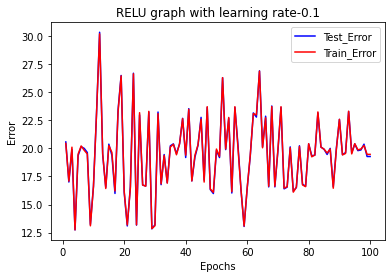

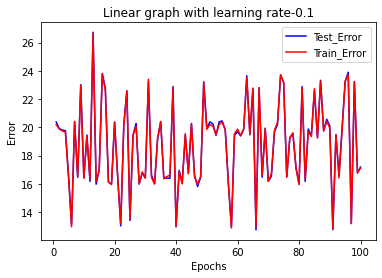

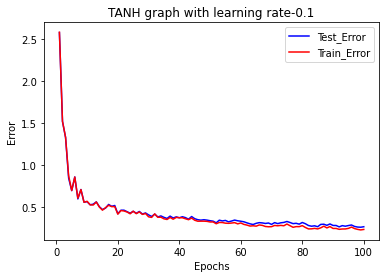

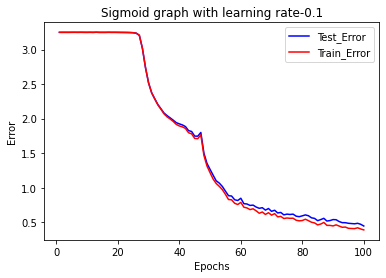

In [7]:

#Traning vs epoch loss

plt.plot(np.linspace(1,100,100), clf_relu.loss_test,  "-b", label="Test_Error" )
plt.plot(np.linspace(1,100,100), clf_relu.loss_train, "-r", label="Train_Error")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("RELU graph with learning rate-0.1") 
plt.savefig(path+'relu_plot.png')
plt.show()

plt.plot(np.linspace(1,100,100), clf_linear.loss_test,  "-b", label="Test_Error" )
plt.plot(np.linspace(1,100,100), clf_linear.loss_train, "-r", label="Train_Error")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("Linear graph with learning rate-0.1") 
plt.savefig(path+'linear_plot.png')
plt.show()

plt.plot(np.linspace(1,100,100), clf_tanh.loss_test,  "-b", label="Test_Error" )
plt.plot(np.linspace(1,100,100), clf_tanh.loss_train, "-r", label="Train_Error")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("TANH graph with learning rate-0.1") 
plt.savefig(path+'tanh_plot.png')
plt.show()

plt.plot(np.linspace(1,100,100), clf_sigmoid.loss_test,  "-b", label="Test_Error" )
plt.plot(np.linspace(1,100,100), clf_sigmoid.loss_train, "-r", label="Train_Error")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("Sigmoid graph with learning rate-0.1") 
plt.savefig(path+'sigmoid_plot.png')
plt.show()

In [8]:

#Model saver

pickle.dump(clf_relu, open(path+'relu_neuralnet.pkl', 'wb'), pickle.HIGHEST_PROTOCOL)
pickle.dump(clf_sigmoid, open(path+'sigmoid_neuralnet.pkl', 'wb'), pickle.HIGHEST_PROTOCOL)
pickle.dump(clf_linear, open(path+'linear_neuralnet.pkl', 'wb'), pickle.HIGHEST_PROTOCOL)
pickle.dump(clf_tanh, open(path+'tanh_neuralnet.pkl', 'wb'), pickle.HIGHEST_PROTOCOL)

#Model Loader
clf_relu = pickle.load(open(path+'relu_neuralnet.pkl', 'rb'))
clf_sigmoid = pickle.load(open(path+'sigmoid_neuralnet.pkl', 'rb'))
clf_linear = pickle.load(open(path+'linear_neuralnet.pkl', 'rb'))
clf_tanh = pickle.load(open(path+'tanh_neuralnet.pkl', 'rb'))

In [9]:

#Accuracy of various model

clf_relu1 = pickle.load(open(path+'relu_neuralnet.pkl', 'rb'))
print("RELU accuracy     : ",clf_relu1.score(testX, testy))
clf_sigmoid1 = pickle.load(open(path+'sigmoid_neuralnet.pkl', 'rb'))
print("SIGMOID accuracy  : ",clf_sigmoid1.score(testX, testy))
clf_linear1 = pickle.load(open(path+'linear_neuralnet.pkl', 'rb'))
print("LINEAR accuracy   : ",clf_linear1.score(testX, testy))
clf_tanh1 = pickle.load(open(path+'tanh_neuralnet.pkl', 'rb'))
print("TANH accuracy     : ",clf_tanh1.score(testX, testy))

RELU accuracy     :  0.1135
SIGMOID accuracy  :  0.9326
LINEAR accuracy   :  0.098
TANH accuracy     :  0.9529


In [10]:
#Load the model with highest test accuracy 
clf = pickle.load(open(path+'tanh_neuralnet.pkl', 'rb'))
#Get the activations of the layer when using train and test data
train_activations = clf.activation_returner(trainX)
test_activations = clf.activation_returner(testX)
#Convert to 2D using tSNE 
train_tsne = TSNE(n_components=2).fit_transform(train_activations[-2].T)
test_tsne = TSNE(n_components=2).fit_transform(test_activations[-2].T)

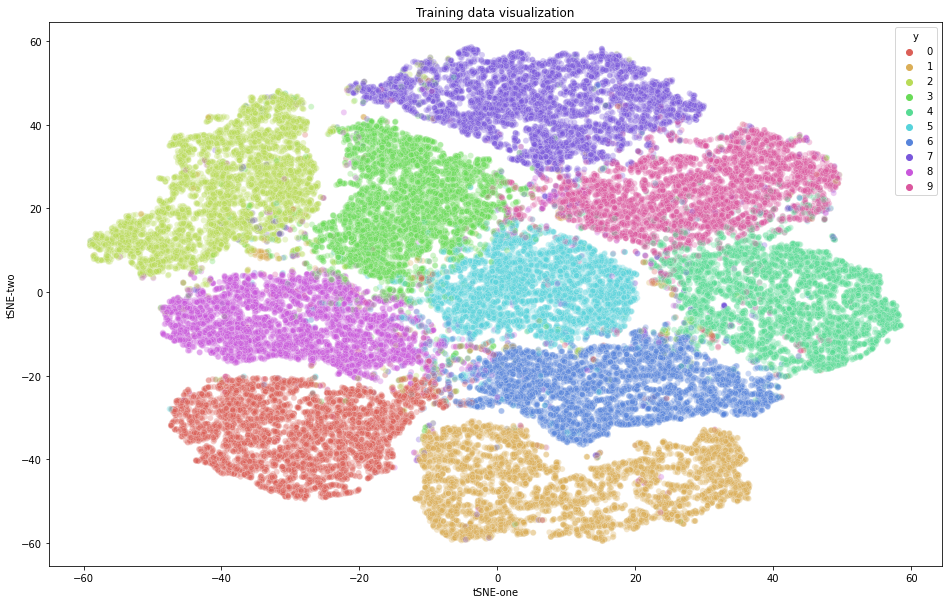

In [11]:
#Create dataframe for tSNE plot
df_train = pd.DataFrame()
df_test = pd.DataFrame()

df_train['tSNE-one'] = train_tsne[:,0]
df_train['tSNE-two'] = train_tsne[:,1] 
df_train['y'] = trainy.T

df_test['tSNE-one'] = test_tsne[:,0]
df_test['tSNE-two'] = test_tsne[:,1] 
df_test['y'] = testy.T

#tSNE plot for training data
plt.figure(figsize=(16,10))
plt.title("Training data visualization") 
scatter = sns.scatterplot(
    x="tSNE-one", y="tSNE-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_train,
    legend="full",
    alpha=0.3,
)
figure = scatter.get_figure()    
figure.savefig(path+'Visualization_Training_Data.png', dpi=400)

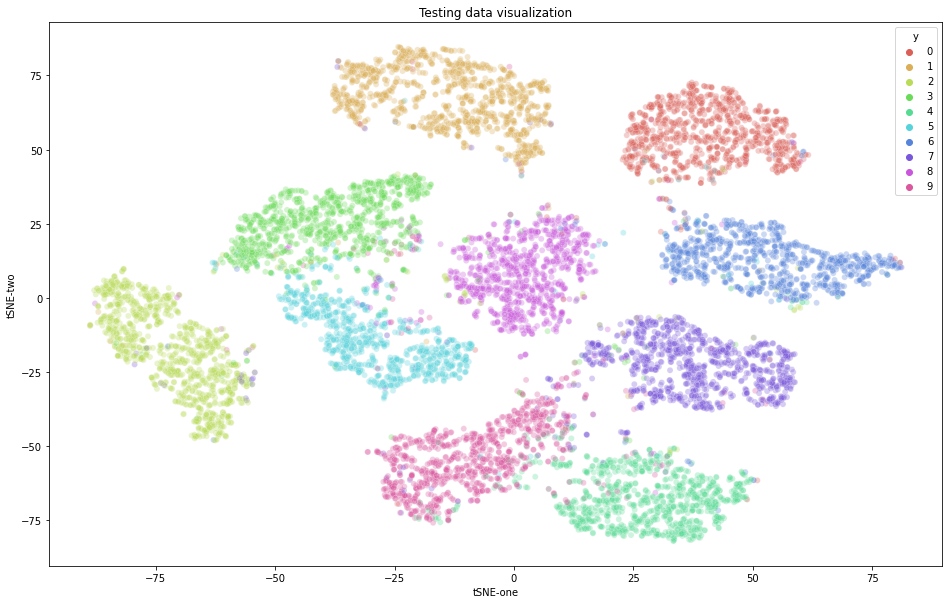

In [12]:
#tSNE plot for testing data
plt.figure(figsize=(16,10))
plt.title("Testing data visualization") 
scatter = sns.scatterplot(
    x="tSNE-one", y="tSNE-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_test,
    legend="full",
    alpha=0.3,   
    )

figure = scatter.get_figure()    
figure.savefig(path+'Visualization_Testing_Data.png', dpi=400)

In [2]:
#Sklearn implementation using MLPClassifier
from sklearn.neural_network import MLPClassifier
for x in ['relu','logistic', 'tanh','identity']:
    clf = MLPClassifier(hidden_layer_sizes= (256, 128, 64) , 
                        solver = "sgd",
                        alpha = 0,
                        batch_size=600,
                        activation=x, 
                        learning_rate_init=0.1, 
                        learning_rate='constant',  
                        n_iter_no_change = 100,
                        random_state=1, 
                        max_iter=100)
    clf.fit(trainX, trainy)
    print("\n",x," Accuracy   : ", clf.score(testX, testy) )

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



 relu  Accuracy   :  0.1135


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



 logistic  Accuracy   :  0.9259


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



 tanh  Accuracy   :  0.7824


/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:151: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:151: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:231: RuntimeWarning: invalid value encountered in double_scalars
  loss += (0.5 * self.alpha) * values / n_samples



 identity  Accuracy   :  0.098


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [16]:
class MyNeuralNetwork_Scaling():

    acti_fns = ['relu', 'sigmoid', 'linear', 'tanh', 'softmax']
    weight_inits = ['zero', 'random', 'normal']
    weights = {}
    n_layers, layer_sizes, activation, learning_rate, batch_size, num_epochs, weight_init = 0,0,0,0,0,0,0
    bias = {}
    loss_train = []
    loss_test = []
    scalar = 0

    def __init__(self, n_layers, layer_sizes, activation, learning_rate, weight_init, batch_size, num_epochs):
        self.n_layers, self.layer_sizes, self.activation, self.learning_rate, self.batch_size, self.num_epochs, self.weight_init = n_layers, layer_sizes, activation, learning_rate, batch_size, num_epochs, weight_init
        self.weights = {}
        self.bias = {}
        self.loss_train = []
        self.loss_test = []
        self.scalar = 0
        if activation not in self.acti_fns:
            raise Exception('Incorrect Activation Function')
        if len(layer_sizes) != n_layers:
            raise Exception('Incorrect Layer Size')    
        if weight_init not in self.weight_inits:
            raise Exception('Incorrect Weight Initialization Function')
        pass

    def relu(self, X):    
        X[X<0]=0           # Changes the value<0 = 0
        return X

    def relu_grad(self, X):
        X = np.clip(X,0,1)   # Changes the value<0 = 0 and value>1 = 1
        X[X>0] = 1           # Changes the 0 < value < 1 = 1
        return X             # Gradient of relu activation function 

    def sigmoid(self, X):
        X = np.clip(X,-100,100)        # Changes the value < -100 = 0 and value > 100 = 1
        z = np.exp(-X)                 # Changes the value of each element in the array to e^(-x)
        return 1/(1+z)                 # Return the sigmoid value of each element in the array

    def sigmoid_grad(self, X):
        #print("hereresigmoid")
        return self.sigmoid(X)*(1-self.sigmoid(X))        #Gradient of sigmoid activation function

    def linear(self, X):
        return X           # Return X after linear activations

    def linear_grad(self, X):
        return np.ones(X.shape)        #Gradient of linear activation function

    def tanh(self, X):
        return np.tanh(X)       # Return X after tanh activations

    def tanh_grad(self, X):
        return 1-self.tanh(X)**2           #Gradient of linear activation function

    def softmax(self, X):
        if( self.activation == 'sigmoid' ):
            return self.softmax_con(X)
        X = np.clip(X,-100,100)                      # Changes the value < -100 = 0 and value > 100 = 1
        expo = np.exp(X)                             # Changes the value of each element in the array to e^(x)
        expo_sum = np.sum(expo, axis=0)              # Calculate the sum of    
        return expo/expo_sum[None,:]
    
    def softmax_con(self,X):
        X = X - np.max(X, axis=0, keepdims=True)
        X = np.clip(X,-100,500)
        expo = np.exp(X)
        expo_sum = np.sum(expo, axis=0)
        return expo/expo_sum[None,:]

    def softmax_grad(self, X):
        return self.softmax(X)*(1-self.softmax(X))     #Gradient of softmax activation function

    def zero_init(self, shape):
        return np.zeros(shape)        #Return 2d zero array of given shape
    
    def random_init(self, shape):
        np.random.seed(20)
        return np.random.rand(shape[0],shape[1]) * 0.01               #Return 2d random array of given shape with scaling of 0.01

    def normal_init(self, shape):
        np.random.seed(20)
        return np.random.normal(scale=1, size = (shape[0],shape[1])) * 0.01       #Return 2d normal array of given shape with scaling of 0.01
    
    def linear_con(self, X):
        #X = np.clip(X,-10,10)
        return X/2

    def linear_grad_con(self, X):
        #print("grad")
        #X = np.clip(X,-10,10)
        return np.ones(X.shape)/2
    
    def activation_convertor(self,X):
        if( self.activation == 'relu'):
            return self.relu(X)
        elif( self.activation == 'sigmoid'):
            return self.sigmoid(X)
        elif( self.activation == 'linear'):
            return self.linear_con(X)
        elif( self.activation == 'tanh'):
            return self.tanh(X)
        elif( self.activation == 'softmax'):
            return self.softmax(X)

    def activation_grad_convertor(self,X):
        if( self.activation == 'relu'):
            return self.relu_grad(X)
        elif( self.activation == 'sigmoid'):
            return self.sigmoid_grad(X)
        elif( self.activation == 'linear'):
            return self.linear_grad_con(X)
        elif( self.activation == 'tanh'):
            return self.tanh_grad(X)
        elif( self.activation == 'softmax'):
            return self.softmax_grad(X)
    
    def new_loss(self, X,y):
        eps = np.finfo(float).eps
        z, a = self.for_2(X)
        logprob = np.multiply(np.log(a[-1]+eps), y) + np.multiply((1 - y), np.log(1 - a[-1]+eps))
        cost = -np.sum(logprob) / y.shape[1]
        return cost
    
    def y_convertor(self,y):
        b = np.zeros((y.size, y.max()+1))
        b[np.arange(y.size),y] = 1
        return b
    
    def weight_generate(self):
        '''
        Function initializes the weights according to the weight_init
        parameter given by the user. Also initializes the bias as 0.
        '''
        for i in range(1, self.n_layers):
            if self.weight_init == 'zero':
                self.weights[i] = self.zero_init( (self.layer_sizes[i],self.layer_sizes[i-1]) )        #Set the ith weights set to be zero
            elif self.weight_init == 'random':
                self.weights[i] = self.random_init( (self.layer_sizes[i],self.layer_sizes[i-1]) )      #Set the ith weights set to be random distribution with scaling of 0.01
            else:
                self.weights[i] = self.normal_init( (self.layer_sizes[i],self.layer_sizes[i-1]) )      #Set the ith weights set to be normal distribution (mean = 0 and variance = 1) with scaling of 0.01
            self.bias[i] = np.zeros(shape=(self.layer_sizes[i], 1))                                    #Set the ith layer neuron bias to 0 
    
    def activation_returner(self,X):
        if( self.activation == 'linear' or self.activation == 'relu'):
            X = self.scaler.transform(X)
        X = X.T
        z,a = self.for_2(X)
        return a

    def for_2(self,X):
        z = [X]
        a = [X]
        for i in range(1,self.n_layers):
            Z1 = np.dot(self.weights[i],X) + self.bias[i]
            z.append(Z1)
            if(i == self.n_layers-1):
                A1 = self.softmax(Z1)
            else:
                A1 = self.activation_convertor(Z1)
            a.append(A1)
            X = A1
        return z, a

    def fitter(self,X,y):
        z,a = self.for_2(X)
        grad_neuron = [0]*self.n_layers
        for j in range(self.n_layers-1,0,-1):
            if(j==self.n_layers-1):
                grad_neuron[j] = a[j] - y
            else:
                try:
                    grad_neuron[j] = np.multiply(np.dot(self.weights[j+1].T, grad_neuron[j+1]), self.activation_grad_convertor(z[j])) 
                except:
                    print(self.activation_grad_convertor(z[j]))
                    print(np.dot(self.weights[j+1].T, grad_neuron[j+1]))
            #if( self.activation == 'sigmoid' ):
                #grad_neuron[j] = np.clip( grad_neuron[j] , (-1)*(10**5) , 10**10)
            #print(grad_neuron[j])
            try:
                self.bias[j] = np.subtract( self.bias[j] , self.learning_rate * np.sum( grad_neuron[j] / self.batch_size , axis=1, keepdims=True) )
                self.weights[j] = np.subtract( self.weights[j] , (self.learning_rate / self.batch_size) * np.dot(grad_neuron[j], a[j-1].T) )
            except :
                print(np.isfinite(grad_neuron[j]).all())     

    def preprocessdata(self, trainX,test_X):
        if( self.activation == 'linear' or self.activation == 'relu'):
            self.scaler = StandardScaler()
            self.scaler.fit(trainX) 
            trainX = self.scaler.transform(trainX)
            test_X = self.scaler.transform(test_X)
        return trainX.T, test_X.T

    def fit_plotter(self, X=0, y=0, test_X=0, test_y=None, verbose=False):
        X,test_X = self.preprocessdata(X,test_X)
        y = self.y_convertor(y).T
        test_y = self.y_convertor(test_y).T
        self.weight_generate()
        
        for i in range(self.num_epochs):
            for j in range( X.shape[1]//self.batch_size):
                indices = np.random.choice( X.shape[1], size=self.batch_size, replace=False)
                X1 = X[ :, indices]
                y1 = y[ :, indices]
                self.fitter(X1,y1)
            if(verbose == True):
                print("----------------------------------------------------------------------")
                print(" ")
                print("Epoch   : ",(i+1))
                cost = self.new_loss(X,y)
                self.loss_train.append(cost)
                print("Training Cost            : ",cost)
                y_pred = self.predict(X.T)
                print("Training Accuracy score  : ",accuracy_score(np.argmax(y, axis=0), y_pred))
                cost = self.new_loss(test_X,test_y)
                self.loss_test.append(cost)
                print("Testing Cost             : ",cost)
                y_pred = self.predict(test_X.T)
                print("Testing Accuracy score   : ",accuracy_score(np.argmax(test_y, axis=0), y_pred))
                print(" ")
        return self, self.loss_train, self.loss_test

    def fit(self, X, y):
        if( self.activation == 'linear' or self.activation == 'relu'):
            self.scaler = StandardScaler()
            self.scaler.fit(X) 
            X = self.scaler.transform(X)
        X = X.T
        self.weight_generate()
        y = self.y_convertor(y).T
        for i in range(self.num_epochs):
            for j in range( X.shape[1]//self.batch_size):
                indices = np.random.choice( X.shape[1], size=self.batch_size, replace=False)
                X1 = X[ :, indices]
                y1 = y[ :, indices]
                self.fitter(X1,y1)
        return self

    def predict_proba(self, X):
        X = X.T
        z,a = self.for_2(X)
        return np.array(a[-1])

    def predict(self, X):
        y = self.predict_proba(X)
        y_pred = np.argmax(y, axis=0)
        return y_pred

    def score(self, X, y):
        if( self.activation == 'linear' or self.activation == 'relu'):
            X = self.scaler.transform(X)
        y_pred = self.predict(X)
        score = 0
        for i in range(len(y)):
            if(y[i]==y_pred[i]):
                score+=1
        return score/len(y)


In [17]:
np.seterr(all='raise')
clf_linear = MyNeuralNetwork_Scaling( 5, [784, 256, 128, 64, 10], 'linear', 0.1, 'normal', 600, 100)
clf_linear.fit_plotter(trainX, trainy, testX, testy, True)

----------------------------------------------------------------------
 
Epoch   :  1
Training Cost            :  3.249473014048106
Training Accuracy score  :  0.11236666666666667
Testing Cost             :  3.249346309718652
Testing Accuracy score   :  0.1135
 
----------------------------------------------------------------------
 
Epoch   :  2
Training Cost            :  3.249287782640905
Training Accuracy score  :  0.11236666666666667
Testing Cost             :  3.249198973681934
Testing Accuracy score   :  0.1135
 
----------------------------------------------------------------------
 
Epoch   :  3
Training Cost            :  3.2492353592585177
Training Accuracy score  :  0.11236666666666667
Testing Cost             :  3.2491027749444137
Testing Accuracy score   :  0.1135
 
----------------------------------------------------------------------
 
Epoch   :  4
Training Cost            :  3.2492413804653566
Training Accuracy score  :  0.11236666666666667
Testing Cost             :  

(<__main__.MyNeuralNetwork_Scaling at 0x7f30fc353828>,
 [3.249473014048106,
  3.249287782640905,
  3.2492353592585177,
  3.2492413804653566,
  3.2492202163344848,
  3.2491914973673754,
  3.24918459422368,
  3.249162062563088,
  3.24916502462372,
  3.2491436780470417,
  3.2490910113229035,
  3.249042910693922,
  3.2490120097644057,
  3.248933146263144,
  3.24885570987891,
  3.2487414206490586,
  3.2485772825274712,
  3.2483113020174206,
  3.2477794500409867,
  3.2466720953356143,
  3.24293760852812,
  3.2087557716561714,
  2.6752446763019453,
  2.5223090341902896,
  2.444853374728261,
  2.392690129962281,
  2.31573225276544,
  1.9065843216021576,
  1.6964294024368294,
  1.6030205292762703,
  1.5581715166775842,
  1.5379126991870964,
  1.524946740081875,
  1.5148158921150985,
  1.5098003709495917,
  1.5046778613797396,
  1.4937073999507695,
  1.4868771021205762,
  1.4807585973503647,
  1.4502300790838212,
  1.3258203672207043,
  1.1998825031373446,
  1.146989532169787,
  1.12124730638275

In [18]:
np.seterr(all='raise')
clf_sigmoid = MyNeuralNetwork_Scaling(5, [784, 256, 128, 64, 10], 'sigmoid', 0.1, 'normal', 600, 100) 
clf_sigmoid.fit_plotter(trainX, trainy, testX, testy, True)

----------------------------------------------------------------------
 
Epoch   :  1
Training Cost            :  3.2496979706790823
Training Accuracy score  :  0.11236666666666667
Testing Cost             :  3.24944528571042
Testing Accuracy score   :  0.1135
 
----------------------------------------------------------------------
 
Epoch   :  2
Training Cost            :  3.2498619406745033
Training Accuracy score  :  0.11236666666666667
Testing Cost             :  3.2499821781862783
Testing Accuracy score   :  0.1135
 
----------------------------------------------------------------------
 
Epoch   :  3
Training Cost            :  3.2499746605907283
Training Accuracy score  :  0.11236666666666667
Testing Cost             :  3.2498146839680206
Testing Accuracy score   :  0.1135
 
----------------------------------------------------------------------
 
Epoch   :  4
Training Cost            :  3.2498283373621177
Training Accuracy score  :  0.11236666666666667
Testing Cost             :

(<__main__.MyNeuralNetwork_Scaling at 0x7f31314500f0>,
 [3.2496979706790823,
  3.2498619406745033,
  3.2499746605907283,
  3.2498283373621177,
  3.250224928898538,
  3.2503544900066066,
  3.249807857898513,
  3.2504157056411587,
  3.249843572214866,
  3.2497156817959785,
  3.249989581878462,
  3.2494727540006267,
  3.2511147427429417,
  3.2495958100550992,
  3.249444339398511,
  3.249724149342701,
  3.2500957562274206,
  3.2497549200700786,
  3.2499145998208645,
  3.24955796043655,
  3.2488237309135846,
  3.248460544904195,
  3.2477606168252513,
  3.2467580395772053,
  3.2445233687613966,
  3.237576621038478,
  3.206860243975284,
  3.019184520927346,
  2.7416050487481614,
  2.5176044021776938,
  2.3756434703024065,
  2.286102289384384,
  2.2008478053910445,
  2.138167933866347,
  2.070540644141906,
  2.0267120523546804,
  1.9947699905586083,
  1.9605387143650546,
  1.916991103264193,
  1.893905782849574,
  1.880671481962771,
  1.857985783311788,
  1.796188393344088,
  1.779613366603675

In [19]:
np.seterr(all='raise')
clf_tanh = MyNeuralNetwork_Scaling(5, [784, 256, 128, 64, 10], 'tanh', 0.1, 'normal', 600, 100)  #Sigmoid
clf_tanh.fit_plotter(trainX, trainy, testX, testy, True)

----------------------------------------------------------------------
 
Epoch   :  1
Training Cost            :  2.582650855848787
Training Accuracy score  :  0.3837333333333333
Testing Cost             :  2.578697099914753
Testing Accuracy score   :  0.3778
 
----------------------------------------------------------------------
 
Epoch   :  2
Training Cost            :  1.5211977900807911
Training Accuracy score  :  0.7201166666666666
Testing Cost             :  1.519059974174557
Testing Accuracy score   :  0.7242
 
----------------------------------------------------------------------
 
Epoch   :  3
Training Cost            :  1.331422528665017
Training Accuracy score  :  0.7134166666666667
Testing Cost             :  1.3293924224194298
Testing Accuracy score   :  0.7154
 
----------------------------------------------------------------------
 
Epoch   :  4
Training Cost            :  0.8719071654423031
Training Accuracy score  :  0.8414666666666667
Testing Cost             :  0.84

(<__main__.MyNeuralNetwork_Scaling at 0x7f313144fc50>,
 [2.582650855848787,
  1.5211977900807911,
  1.331422528665017,
  0.8719071654423031,
  0.6972094379024553,
  0.8575538466046149,
  0.6053342358393696,
  0.7081685842932751,
  0.5566699786720489,
  0.5685925333572283,
  0.5264838229721509,
  0.5242681557035935,
  0.5601181110082815,
  0.500267841235925,
  0.46292132365809524,
  0.49224092902758154,
  0.5211235349122865,
  0.5048361181874429,
  0.5055902821639735,
  0.41546991203002126,
  0.45774049279029366,
  0.45338780612886537,
  0.44097970753099963,
  0.41987364733039134,
  0.450312515587529,
  0.42147466332322153,
  0.44180961750386843,
  0.41241829274734587,
  0.4234021433366604,
  0.3835850717665724,
  0.3766899908875025,
  0.418593464187377,
  0.37807417195522425,
  0.3793020287952977,
  0.35993973289123515,
  0.3519336751048942,
  0.3760188922712438,
  0.3549240017625304,
  0.37660696306995933,
  0.37274412684223196,
  0.3727358741959008,
  0.3603852635264083,
  0.34927211

In [20]:
np.seterr(all='raise')
clf_relu = MyNeuralNetwork_Scaling(5, [784, 256, 128, 64, 10], 'relu', 0.03, 'normal', 600, 100)  #Sigmoid
clf_relu.fit_plotter(trainX, trainy, testX, testy, True)

----------------------------------------------------------------------
 
Epoch   :  1
Training Cost            :  3.2501002821625256
Training Accuracy score  :  0.11236666666666667
Testing Cost             :  3.2500548063980617
Testing Accuracy score   :  0.1135
 
----------------------------------------------------------------------
 
Epoch   :  2
Training Cost            :  3.2497024614193917
Training Accuracy score  :  0.11236666666666667
Testing Cost             :  3.2496481191023645
Testing Accuracy score   :  0.1135
 
----------------------------------------------------------------------
 
Epoch   :  3
Training Cost            :  3.249437400681884
Training Accuracy score  :  0.11236666666666667
Testing Cost             :  3.2493524797883415
Testing Accuracy score   :  0.1135
 
----------------------------------------------------------------------
 
Epoch   :  4
Training Cost            :  3.2492787798528733
Training Accuracy score  :  0.11236666666666667
Testing Cost             

(<__main__.MyNeuralNetwork_Scaling at 0x7f30fc627128>,
 [3.2501002821625256,
  3.2497024614193917,
  3.249437400681884,
  3.2492787798528733,
  3.249211102317659,
  3.2491590695516326,
  3.249132266146136,
  3.2490920847849507,
  3.249062579557393,
  3.249026344047355,
  3.2489795938857586,
  3.2489295916973746,
  3.2488722362898734,
  3.2488089650736227,
  3.2487251497679455,
  3.2486275706454784,
  3.2485002805982046,
  3.2483436028551393,
  3.2481320786582004,
  3.247850015142177,
  3.2474488395423866,
  3.2468537013594094,
  3.2459161786156474,
  3.244241717548683,
  3.2407694284387905,
  3.2313127883190482,
  3.1840815570300323,
  2.972389712533653,
  2.857469476724224,
  2.7047870027582084,
  2.500276961731705,
  2.34741572209579,
  2.074885054130901,
  1.6766355279915806,
  1.3920353203093587,
  1.1469374775641052,
  0.96169711864656,
  0.8261522536150224,
  0.7190232068936452,
  0.6382254819564455,
  0.5793331904882304,
  0.5285009585242734,
  0.4868606268772324,
  0.4492941464

In [21]:
#Model saver

pickle.dump(clf_relu, open(path+'Weights/WeightsForScaledDataset/'+'relu_neuralnet.pkl', 'wb'), pickle.HIGHEST_PROTOCOL)
pickle.dump(clf_sigmoid, open(path+'Weights/WeightsForScaledDataset/'+'sigmoid_neuralnet.pkl', 'wb'), pickle.HIGHEST_PROTOCOL)
pickle.dump(clf_linear, open(path+'Weights/WeightsForScaledDataset/'+'linear_neuralnet.pkl', 'wb'), pickle.HIGHEST_PROTOCOL)
pickle.dump(clf_tanh, open(path+'Weights/WeightsForScaledDataset/'+'tanh_neuralnet.pkl', 'wb'), pickle.HIGHEST_PROTOCOL)

In [22]:
print("Accuracy score for scaled neural network class  - ")
clf_relu1 = pickle.load(open(path+'Weights/WeightsForScaledDataset/'+'relu_neuralnet.pkl', 'rb'))
print("RELU accuracy     : ",clf_relu1.score(testX, testy))
clf_sigmoid1 = pickle.load(open(path+'Weights/WeightsForScaledDataset/'+'sigmoid_neuralnet.pkl', 'rb'))
print("SIGMOID accuracy  : ",clf_sigmoid1.score(testX, testy))
clf_linear1 = pickle.load(open(path+'Weights/WeightsForScaledDataset/'+'linear_neuralnet.pkl', 'rb'))
print("LINEAR accuracy   : ",clf_linear1.score(testX, testy))
clf_tanh1 = pickle.load(open(path+'Weights/WeightsForScaledDataset/'+'tanh_neuralnet.pkl', 'rb'))
print("TANH accuracy     : ",clf_tanh1.score(testX, testy))

Accuracy score for scaled neural network class  - 
RELU accuracy     :  0.9695
SIGMOID accuracy  :  0.9326
LINEAR accuracy   :  0.8991
TANH accuracy     :  0.9529
